# SUMMARY - Flat Rental Analysis:

- Using the data I scraped from Openrent (data_collection.py) I conducted a more in-depth analysis on each listing feature to see whether or not I'd be able to predict a "fair" monthly rent which would be useful for identifying undervalued properties for further analysis.

- One of the first things I did in this notebook (and before training any future model) was remove obvious outliers. There were a few listings that were for 15K+ per month in rent. Since these sort of listings would skew the mean heavily I removed them using the Inter Quartile Range (IQR) filter.

<u><strong> MODEL PERFORMANCE:</strong> </u>

- Trained & Optimised a Random Forest Regression model with an average RMSE of 112.53 across 5-fold cross validation. 

- Utilised custom model to predict a "fair" value for monthly rent based on each listings attributes from Openrent.


<u><strong>KEY TAKEAWAYS FROM EXPLORATORY DATA ANALYSIS:</strong></u>
* The features most closely correlated with the target variable (rent_pcm) at this stage are max_tenants & deposit. 

* The only other surprising thing that stood out immediately was that flats with bills included tended to have a lower median monthly rent than those without. This could be due to the fact that these listings are for rooms only in flatshares where the other flatmates already have bills set up.


<u><strong>ENGINEERED FEATURES TO IMPROVE MODEL PERFORMANCE:</strong></u>
*  Utilsied the listing title to create a "type" feature which would classify the listing into one of 4 classes. I wanted to seperate the listings in shared accomodations (with many unknown roommates), and those for studio apartments from typical flats. I also wanted to identify the typically larger listings; i.e maisonettes. 

* Parsed the postcode feature to map each listing to it's region within London. The Tableau dashboard I created for in-depth analysis uses more precisise mapping, but for  this model building I found that distinguishing between North, East, South & West was sufficient.
    
* Created a "bedroom/bathroom_ratio" feature. Since the # of bedrooms and # of bathrooms were highly correlated with one another, I combined them into this new feature to try and avoid any multicolinearity which would hinder a regression model.
     
*The above features were also added into the scraper itself, so the features are engineered now during the scraping process.*


* I also tried experimenting with an "available_season" feature to see if certain months were cheaper to move. However for this analysis this wouldn't provide much value as the majority of observations would always fall in the current season, due to the nature of the London housing market.




## CONTENTS


### [Imports](#IMPORTS)

### [Data Overview](#DATA-OVERVIEW)

### [Useful Functions](#HELPFUL-FUNCTIONS)

### [Exploratory Data Analysis](#EDA-&-CLEANING)

### [Feature Engineering](#FEATURE-ENGINEERING)

### [Model Building & Training](#MODEL-BUILDING)

## IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## DATA OVERVIEW

In [2]:
data = pd.read_csv('all_rental_data.csv')
data.head(2)

,property_id,property_link,listing_title,description,location,num_bedrooms,num_bathrooms,max_tenants,deposit,rent_pcm,...,fireplace,furnishing,closest_station,closest_station_mins,postcode,listing_type,region_loc,bed_bath_ratio,scrape_date,predicted_monthly_rent
0,1214879,https://www.openrent.co.uk//1214879,"Studio Flat, Charles Apartments, WC2R",We are proud to offer this delightful 1 bedroo...,London,1,1,2,3461,3000,...,No,Furnished,"Charing Cross Station, Underground Station",3,WC2R,studio,west,1.0,29 September 2021,3000.14
1,1211579,https://www.openrent.co.uk//1211579,"Studio Flat, Shaftesbury Avenue, W1D",12 months minimum contract.Please enquiry for ...,London,1,1,2,2076,1800,...,No,Furnished,Piccadilly Circus Station,2,W1D,studio,west,1.0,29 September 2021,1804.25


In [3]:
# Check for nulls & data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_id             2452 non-null   int64  
 1   property_link           2452 non-null   object 
 2   listing_title           2452 non-null   object 
 3   description             2452 non-null   object 
 4   location                2452 non-null   object 
 5   num_bedrooms            2452 non-null   int64  
 6   num_bathrooms           2452 non-null   int64  
 7   max_tenants             2452 non-null   int64  
 8   deposit                 2452 non-null   int64  
 9   rent_pcm                2452 non-null   int64  
 10  bills_included          2452 non-null   object 
 11  student_friendly        2452 non-null   object 
 12  family_friendly         2452 non-null   object 
 13  pet_friendly            2452 non-null   object 
 14  smoker_friendly         2452 non-null   

In [4]:
data.describe()

,property_id,num_bedrooms,num_bathrooms,max_tenants,deposit,rent_pcm,min_tenancy_months,closest_station_mins,bed_bath_ratio,predicted_monthly_rent
count,2.452000e+03,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000
mean,1.182565e+06,1.981648,1.414763,2.769168,2420.982055,2654.644780,7.679445,6.215334,1.474273,2330.978842
std,1.105762e+05,1.122482,0.662323,1.567904,2117.152941,1922.379486,4.434116,3.764503,0.830881,1152.385363
min,8.031800e+04,1.000000,1.000000,1.000000,0.000000,550.000000,1.000000,1.000000,0.333333,589.500000
25%,1.190230e+06,1.000000,1.000000,2.000000,1000.000000,1450.000000,6.000000,3.000000,1.000000,1430.660000
50%,1.213800e+06,2.000000,1.000000,2.000000,1950.000000,2145.000000,6.000000,5.000000,1.000000,2086.110000
75%,1.222872e+06,3.000000,2.000000,4.000000,3000.000000,3250.000000,12.000000,8.000000,2.000000,3248.000000
max,1.234087e+06,6.000000,5.000000,12.000000,15500.000000,15500.000000,30.000000,23.000000,5.000000,4467.970000


## HELPFUL FUNCTIONS

In [5]:
# Remove outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# Plot a categorical feature against target feature
def plot_categorical_feature(data, feature, target_feature, estimator = np.median):
    if feature != target_feature:
        plt.figure(figsize=(15,8))
    
        # Plot Distribution
        plt.subplot(1,2,1)
        sns.countplot(data[feature])
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('# Observations', fontsize=12)
        plt.title(f'Distribution of {feature}', fontsize=14);

        # Plot against target feature
        plt.subplot(1,2,2)
        sns.barplot(x = feature, y=target_feature, data = data, estimator=estimator)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel(f'{target_feature}', fontsize=12)
        plt.title(f'{target_feature} vs {feature}', fontsize=14);
    else:
        pass

## EDA & CLEANING

### Check initial distributions

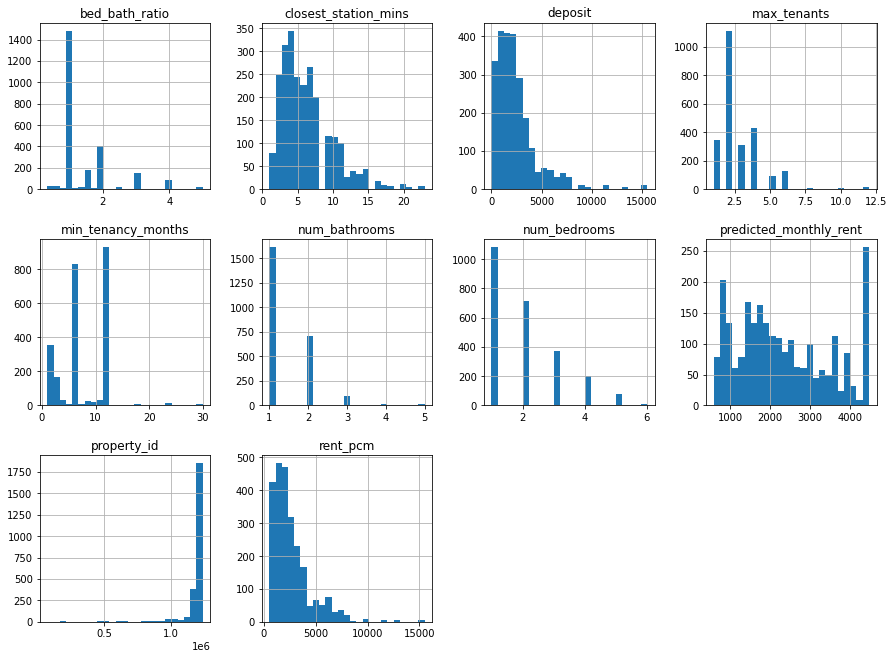

In [6]:
data.hist(bins=25, layout=(4,4), figsize=(15,15));

Using both the histograms generated above, as well as information from the .describe method used above, I can tell that there seem to be a couple of outliers; most obviously in the rent_pcm and deposit features. 

Since this data suffers from outliers and the mean will therefore be affected, I chose to use the Inter Quartile Range (IQR) to filter out data points that are skewing the distribution.

In [7]:
data = remove_outlier(data, 'deposit')
data = remove_outlier(data, 'rent_pcm')

In [8]:
data.describe()

,property_id,num_bedrooms,num_bathrooms,max_tenants,deposit,rent_pcm,min_tenancy_months,closest_station_mins,bed_bath_ratio,predicted_monthly_rent
count,2.194000e+03,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000
mean,1.180807e+06,1.899727,1.304923,2.548769,1992.416135,2139.731996,7.897903,6.366910,1.509268,2112.664080
std,1.163758e+05,1.114907,0.545682,1.409252,1234.018930,1063.847301,4.438521,3.838607,0.864329,1006.758805
min,8.031800e+04,1.000000,1.000000,1.000000,0.000000,550.000000,1.000000,1.000000,0.333333,589.500000
25%,1.191530e+06,1.000000,1.000000,2.000000,1000.000000,1300.000000,6.000000,4.000000,1.000000,1363.450000
50%,1.214206e+06,2.000000,1.000000,2.000000,1850.000000,1900.000000,6.000000,6.000000,1.000000,1935.365000
75%,1.223057e+06,2.000000,2.000000,3.000000,2800.000000,2800.000000,12.000000,8.000000,2.000000,2804.320000
max,1.234087e+06,6.000000,5.000000,12.000000,5769.000000,5250.000000,30.000000,23.000000,5.000000,4467.970000


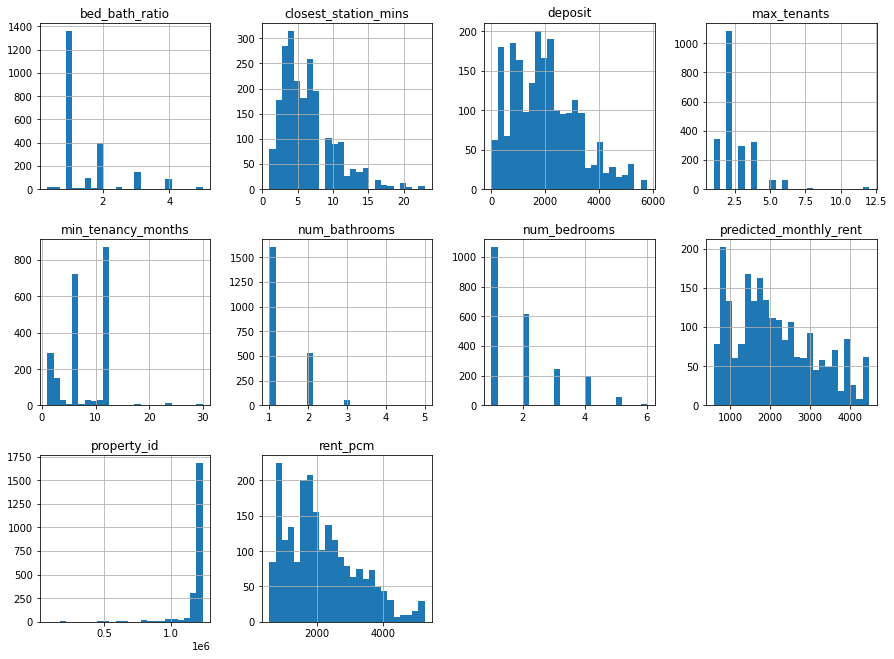

In [9]:
data.hist(bins=25, layout=(4,4), figsize=(15,15));

I can see that the deposit & rent_pcm features already look a little bit better, and more normally distributed now that the obvious outliers have been removed. First I will need to split the data into a training and a test set.

In [10]:
# Split data
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
print('Proportion of training set:',len(data_train)/len(data)*100,'%')
print('Proportion of testing set:',len(data_test)/len(data)*100,'%')

# copy training data to make below steps easier
data = data_train.copy()

Proportion of training set: 79.99088422971741 %
Proportion of testing set: 20.00911577028259 %


### More in-depth EDA

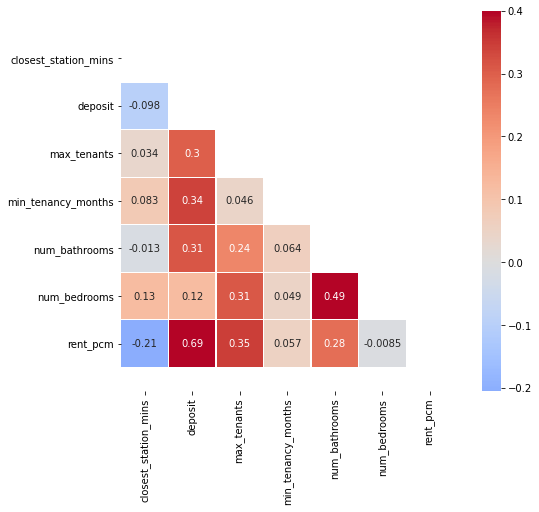

In [11]:
# Check correlations between continuous features
corr_mat = data[['closest_station_mins','deposit','max_tenants','min_tenancy_months',
                     'num_bathrooms','num_bedrooms','rent_pcm']].corr()
corr_mat

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mat, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mat, mask=mask, cmap='coolwarm', vmax = 0.4, center=0, square=True,
             linewidths=0.2,annot = True)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t); # update the ylim(bottom, top) values

The features most closely correlated with the target variable (rent_pcm) at this stage are max_tenants & deposit. 

In [12]:
# Explore the categorical features (postcode will be explored seperately)
data_cat = data[['bills_included','student_friendly', 'family_friendly', 'pet_friendly', 'smoker_friendly', 
                 'garden','parking', 'fireplace', 'furnishing', 'rent_pcm']]

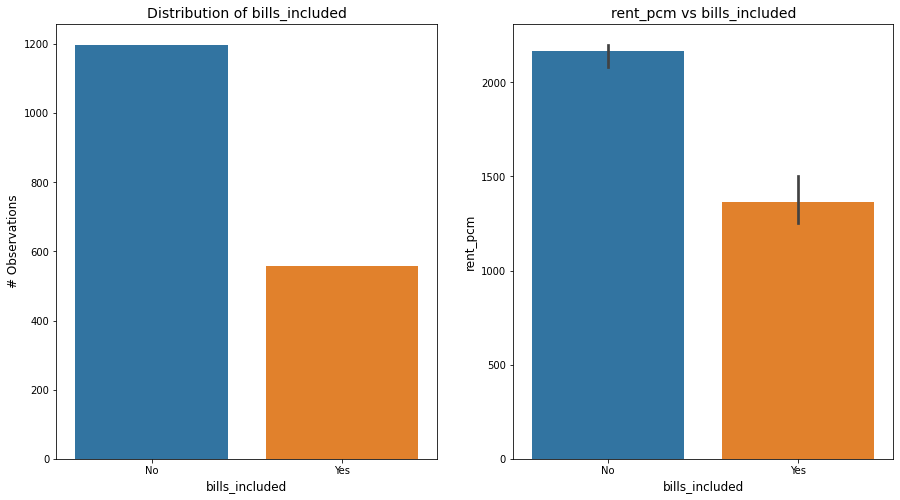

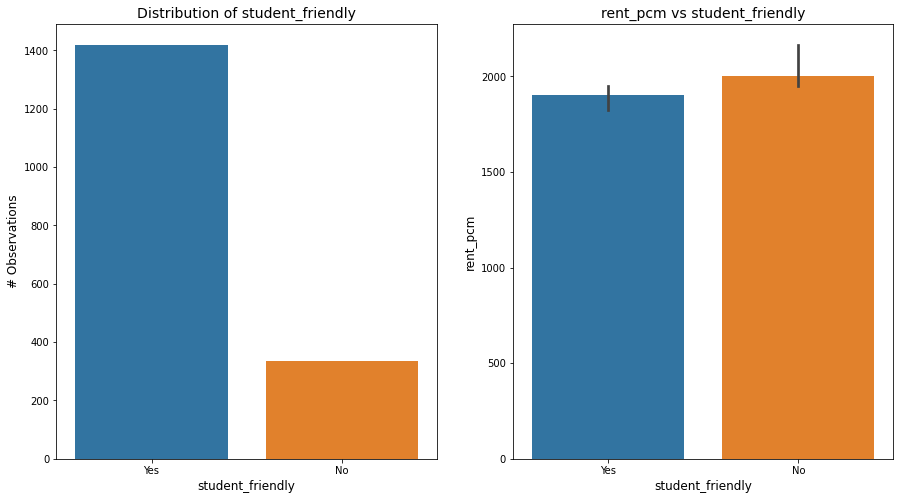

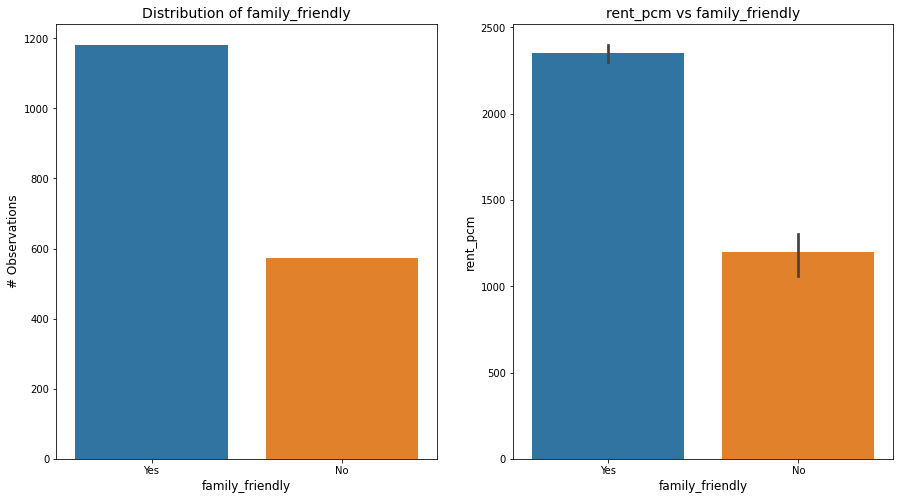

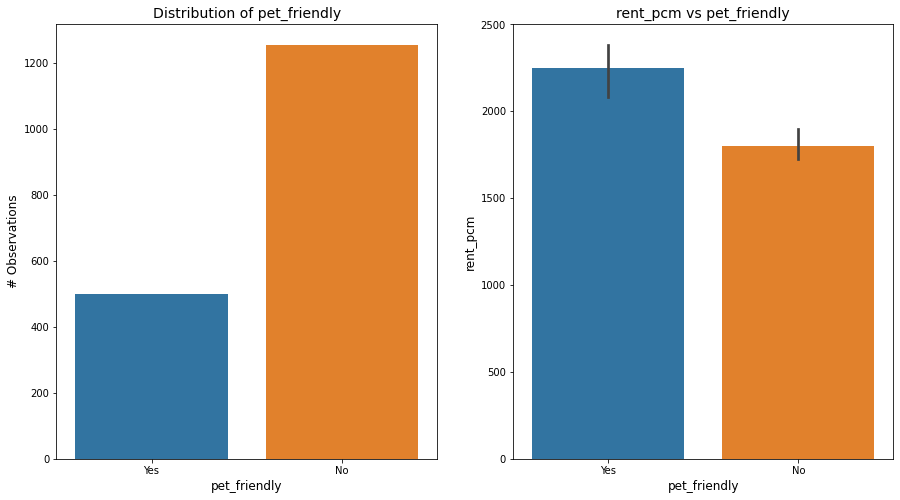

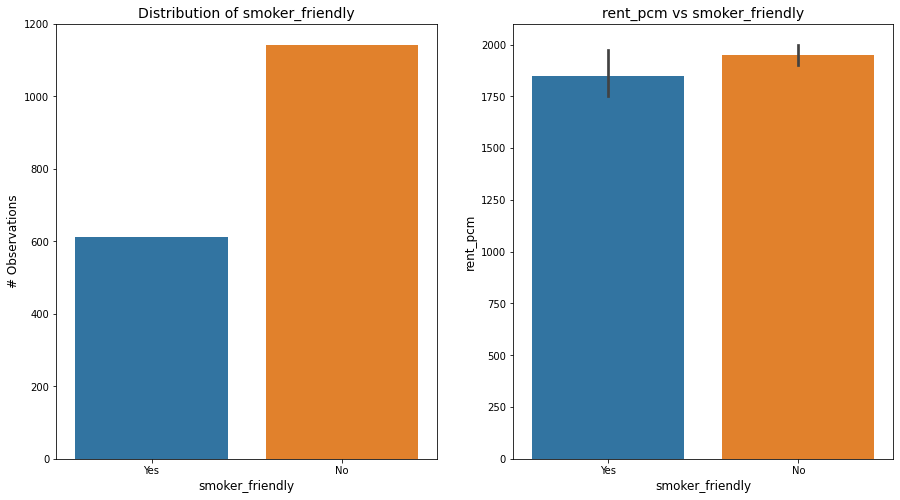

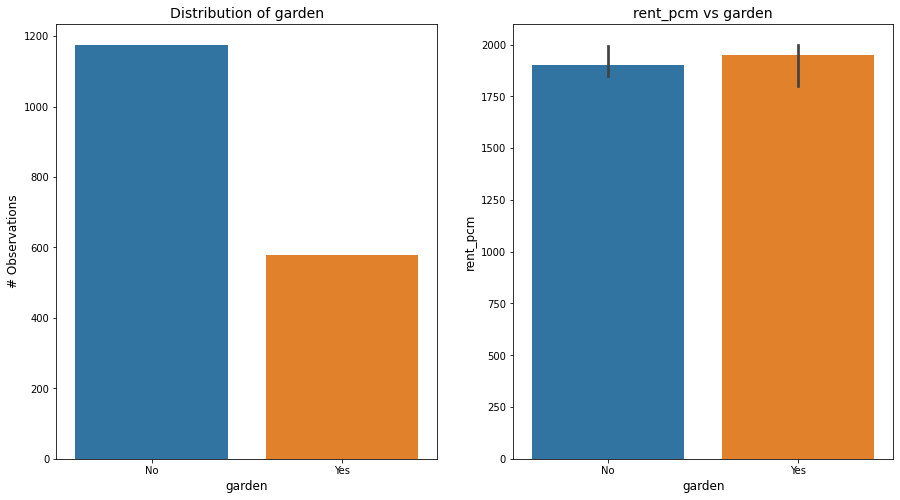

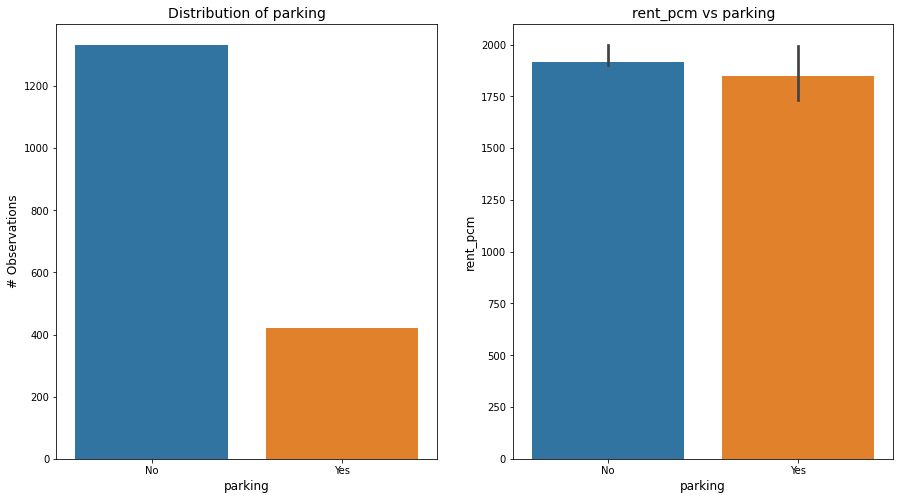

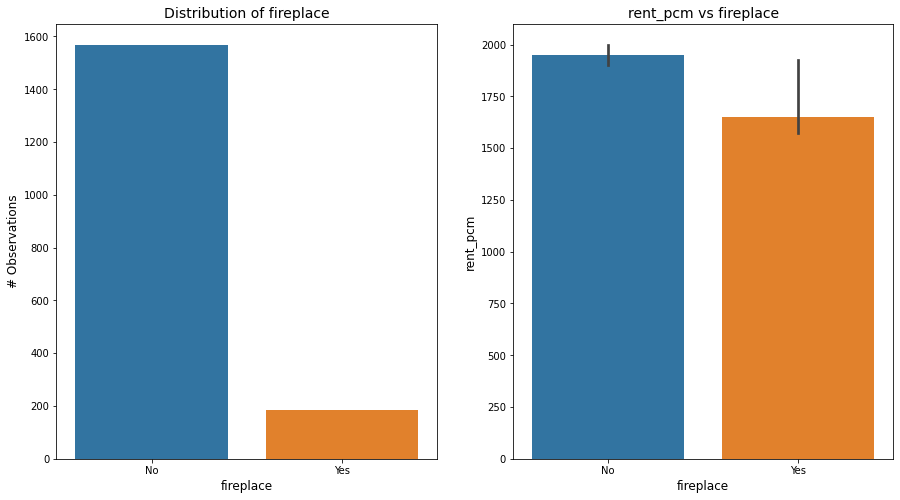

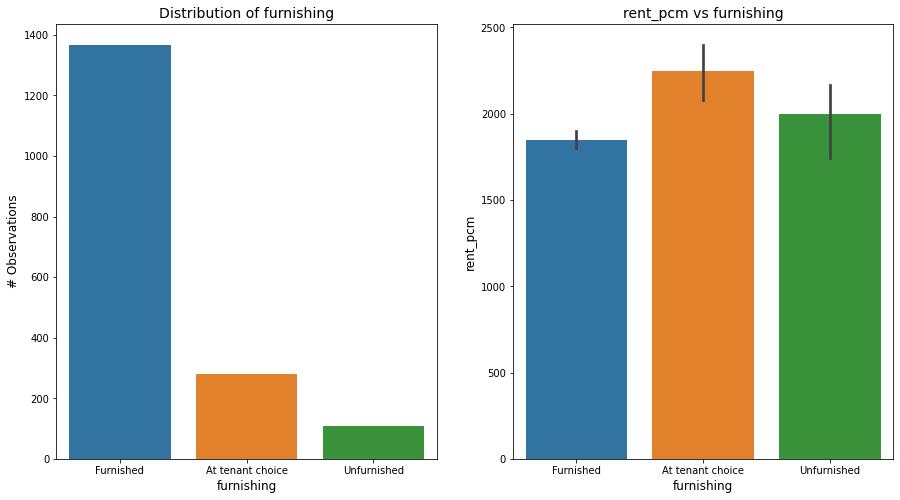

In [13]:
for feature in data_cat.columns: 
    plot_categorical_feature(data_cat, feature, 'rent_pcm')


There is nothing too surprising about monthly rent compared to some of the specs of the flat. The only thing that stood out immediately was that flats with bills included tended to have a lower median monthly rent than those without. This could be due to the fact that these listings are for rooms only in flatshares where the other flatmates already have bills set up. Or it could simply be due to the low number of listings I had at the time of creating this notebook.

In [14]:
# Create pivot table for neighbourhood
pd.set_option('display.max_rows', None)
print(pd.pivot_table(data = data, index = 'postcode', values = 'rent_pcm', 
            aggfunc = 'median').sort_values('rent_pcm', ascending = False))

          rent_pcm
postcode          
W1K         5200.0
NW8         3900.0
EC4A        3800.0
EC4V        3800.0
EC2A        3800.0
EC1Y        3600.0
W1G         3595.0
WC2E        3358.0
W1T         3250.0
WC1E        3141.0
WC2R        3000.0
SW1X        3000.0
EC1N        2975.0
W1J         2925.0
WC2A        2816.0
W8          2800.0
EC1V        2750.0
EC1M        2700.0
SW10        2650.0
WC1H        2600.0
SW4         2600.0
WC2B        2556.0
WC1R        2550.0
SW1V        2383.0
EC1R        2300.0
EC2Y        2285.5
W1F         2275.0
SW11        2200.0
SE16        2166.0
W9          2145.0
SE11        2085.0
N5          2080.0
SW1H        2000.0
SE1         2000.0
SW8         1993.0
E1W         1987.5
SW5         1950.0
W2          1950.0
SE17        1950.0
SW7         1915.0
E8          1900.0
E1          1900.0
NW5         1875.0
W1D         1850.0
NW3         1835.0
W1B         1795.0
SW3         1750.0
W1H         1700.0
SW1P        1650.0
NW1         1600.0
N1          

There don't seem to be any real patterns jumping out at me when looking at the postcodes for these listings. Each area has both some expensive and some cheaper listings.

## FEATURE ENGINEERING

In [15]:
# TYPE OF ACCOMODATION
type_conditions = [
    (data['listing_title'].str.lower().str.contains('studio')),
    (data['listing_title'].str.lower().str.contains('shared')),
    (data['listing_title'].str.lower().str.contains('maisonette'))
    ]
type_values = ['studio', 'shared', 'maisonette']

In [16]:
data['listing_type'] = np.select(type_conditions, type_values, default='flat')

In [17]:
data[['listing_title', 'listing_type']].head()

,listing_title,listing_type
1958,"1 Bed Flat, St. Rule Street, SW8",flat
1004,"2 Bed Flat, Siddal Apartments, SE17",flat
2323,"2 Bed Flat, Camden Street, NW1",flat
2047,"Studio Flat, King Henrys Road, NW3",studio
191,"1 Bed Flat, Copenhagen Street, N1",flat


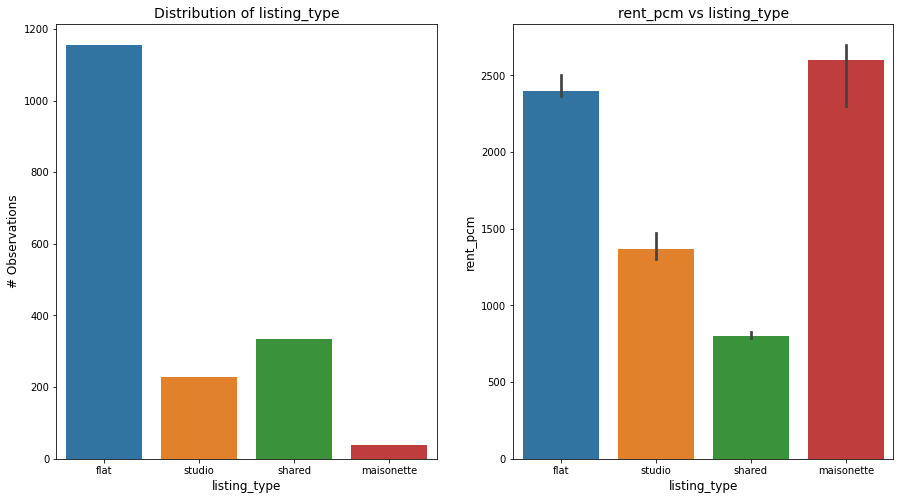

In [18]:
# Check distribution of new feature
plot_categorical_feature(data, 'listing_type', 'rent_pcm')

This new feature is in line with what one would expect; maisonettes being most expensive followed by flats, studios and then rooms in shared houses being cheapest.

In [19]:
# LOCATION WITHIN LONDON
loc_conditions = [
    (data['postcode'].str[0].str.lower() == 'n'),
    (data['postcode'].str[0].str.lower() == 's'),
    (data['postcode'].str[0].str.lower() == 'e'),
    (data['postcode'].str[0].str.lower() == 'w')
    ]
loc_values = ['north', 'south', 'east', 'west']

data['region_loc'] = np.select(loc_conditions, loc_values)

data[['postcode', 'region_loc']].head()

,postcode,region_loc
1958,SW8,south
1004,SE17,south
2323,NW1,north
2047,NW3,north
191,N1,north


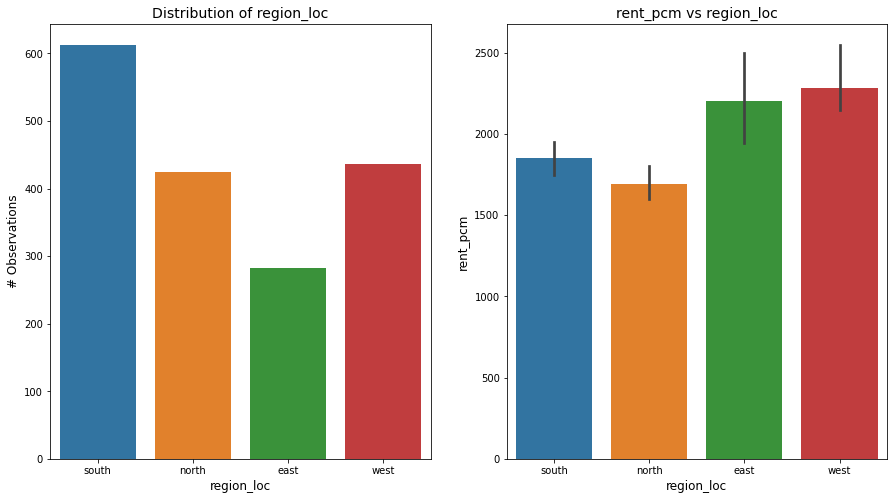

In [20]:
# Check distribution of new feature
plot_categorical_feature(data, 'region_loc', 'rent_pcm')

In [21]:
# BED TO BATH RATIO
data['bed_bath_ratio'] = data['num_bedrooms'] / data['num_bathrooms']
data[['num_bedrooms', 'num_bathrooms', 'bed_bath_ratio']].head()

,num_bedrooms,num_bathrooms,bed_bath_ratio
1958,1,1,1.0
1004,2,2,1.0
2323,2,1,2.0
2047,1,1,1.0
191,1,1,1.0


In [22]:
# Check correlation with target
corr_mat = data[['bed_bath_ratio','num_bathrooms','num_bedrooms','rent_pcm']].corr()
corr_mat

,bed_bath_ratio,num_bathrooms,num_bedrooms,rent_pcm
bed_bath_ratio,1.000000,-0.151775,0.756192,-0.205163
num_bathrooms,-0.151775,1.000000,0.485180,0.276421
num_bedrooms,0.756192,0.485180,1.000000,-0.008501
rent_pcm,-0.205163,0.276421,-0.008501,1.000000


In [23]:
# AVAILABILITY SEASON
season_map = {'Jan':'Winter' , 'Feb':'Winter', 'Mar':'Spring', 'Apr':'Spring', 
                   'May':'Spring', 'Jun':'Summer', 'Jul':'Summer', 'Aug':'Summer', 
                   'Sep':'Fall', 'Oct':'Fall', 'Nov':'Fall', 'Dec':'Winter'}


data['available_season'] = data['available_from'].apply(lambda x: season_map[x[3:6]])

data[['available_from', 'available_season']].head()

,available_from,available_season
1958,"13 October, 2021",Fall
1004,"15 November, 2021",Fall
2323,12 October 2021,Fall
2047,09 October 2021,Fall
191,29 September 2021,Fall


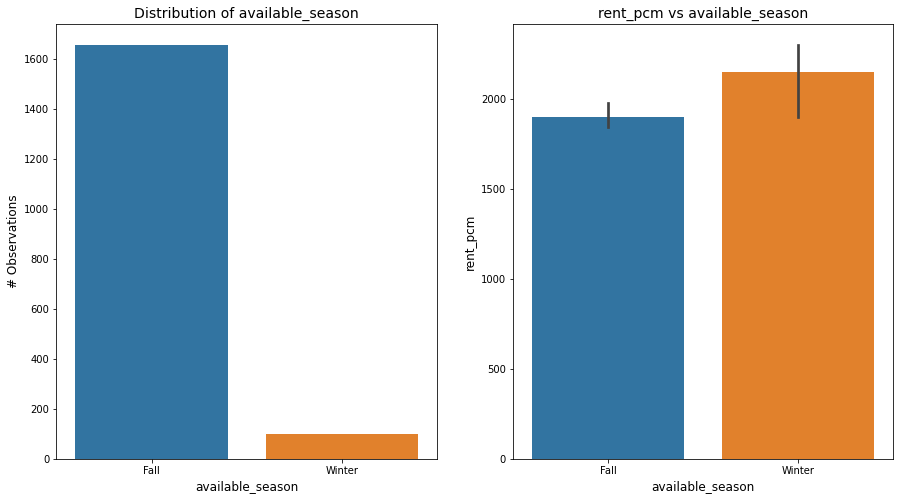

In [24]:
plot_categorical_feature(data, 'available_season', 'rent_pcm')


This feature likely will not be very useful as there are not even observations spread out over all of the months. Typically places in London are available within a few weeks of being listed.

## MODEL BUILDING

In [25]:
data_train = data
len(data_train)

X_train = data_train.drop('rent_pcm', axis=1)
y_train = data_train['rent_pcm']

In [26]:
# Create a pipeline to transform data (assuming all other features are engineered during scrape)
categorical_features = ['bills_included','student_friendly', 'family_friendly', 'pet_friendly',
                        'smoker_friendly', 'garden', 'parking', 'fireplace', 'furnishing', 
                        'listing_type', 'region_loc']
numeric_features = ['num_bedrooms', 'num_bathrooms', 'max_tenants', 'deposit',
                    'min_tenancy_months','closest_station_mins', 'bed_bath_ratio']

categorical_pipe = Pipeline(steps= [
    ('one_hot_encode', OneHotEncoder(sparse=False))
    ])

numerical_pipe = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
    
])


full_pipeline = ColumnTransformer([
    ('cat_pipeline', categorical_pipe, categorical_features),
    ('num_pipeline', numerical_pipe, numeric_features)                                              
])

In [27]:
# Fit Pipeline Transformer and pickle for later use
X_train_prep = full_pipeline.fit_transform(X_train)
dump(full_pipeline, 'full_pipeline.joblib')

['full_pipeline.joblib']

### Model Evaluation

In [29]:
# Linear Regression
lm  = LinearRegression()
lm.fit(X_train_prep, y_train)

# Perform cross validation with Mean Absolute Error as metric
cvs = cross_val_score(lm, X_train_prep, y_train, scoring = 'neg_mean_squared_error', cv = 5)

# Calculate metrics
housing_preds = lm.predict(X_train_prep)
lin_rmse = round(np.mean(cvs * -1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',lin_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 313611.24
----------


In [30]:
# Random Forest 
rfr = RandomForestRegressor(random_state=4, n_estimators=50)

# Fit baseline model using training data
cvs = cross_val_score(rfr, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
rfr_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',rfr_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 114.87
----------


In [31]:
# Lasso Regression
lasso_r = Lasso(random_state=4)

# Fit baseline model using training data
cvs = cross_val_score(lasso_r, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
lasso_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',lasso_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 557.66
----------


In [32]:
# Support Vector Regression
svr = SVR()

# Fit baseline model using training data
cvs = cross_val_score(svr, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
svm_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',svm_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 1045.01
----------


In [33]:
# KNN Regression
knn = KNeighborsRegressor()

# Fit baseline model using training data
cvs = cross_val_score(knn, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
knn_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',knn_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 312.02
----------


### Model Tuning

In [34]:
# Hyperparameter tuning
param_grid = {'n_estimators':[25,50,100,150], 'max_features':['auto','sqrt','log2','None']}

# Initialise model
rfr = RandomForestRegressor(random_state=4)

# Perform gridsearchCV
grid = GridSearchCV(rfr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, refit=True)

# Fit grid to prepared training data
grid.fit(X_train_prep, y_train)

# Calculate RMSE using best score
tuned_rfr_rmse = round(np.sqrt(grid.best_score_*-1),2)

# Create tuned regressor using the best estimator found via GridSearch
tuned_rfr = grid.best_estimator_


# Print feedback
print('FEEDBACK')
print('-'*10)
print('Default Parameters:', knn.get_params())
print('\n')
print('Best Parameters:',grid.best_params_)
print('\n')
print('RMSE for best estimator:',tuned_rfr_rmse)
print('-'*10)

FEEDBACK
----------
Default Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


Best Parameters: {'max_features': 'auto', 'n_estimators': 100}


RMSE for best estimator: 112.53
----------


In [35]:
# Try predicting a few labels with tuned regressor
some_data = X_train.iloc[14:37]
some_labels = y_train.iloc[14:37]

# Transform new data
some_data_prepared = full_pipeline.transform(some_data)

# Print predictions
test_preds = tuned_rfr.predict(some_data_prepared)

pd.DataFrame({'actual_rent':some_labels, 'predicted_rent':test_preds})

,actual_rent,predicted_rent
2186,2600,2599.900000
1053,1550,1538.490000
1228,3683,3685.970000
2067,3100,3112.090000
1434,1700,1732.350000
25,2255,2343.850000
846,2000,1999.300000
737,1733,1756.470000
1763,985,955.050000
426,2195,2197.100000


In [36]:
# Dump tuned Random Forest Model
dump(tuned_rfr, 'tuned_model.joblib')

['tuned_model.joblib']